# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

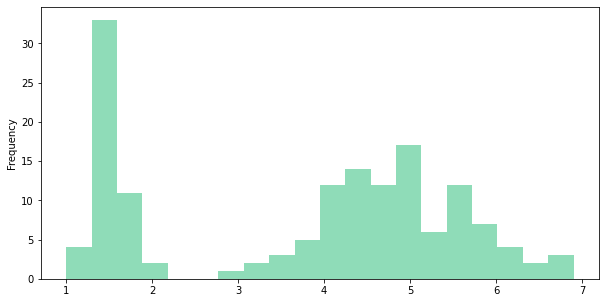

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

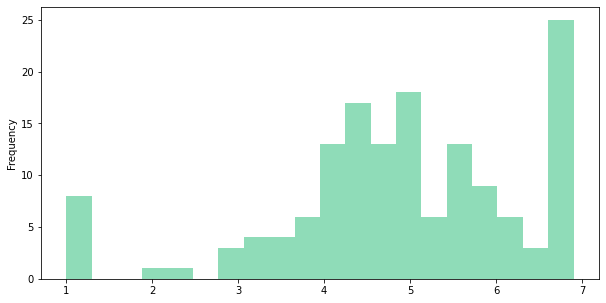

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [7]:
### снова выбросы :-(
### убираем выброс минимумов ...

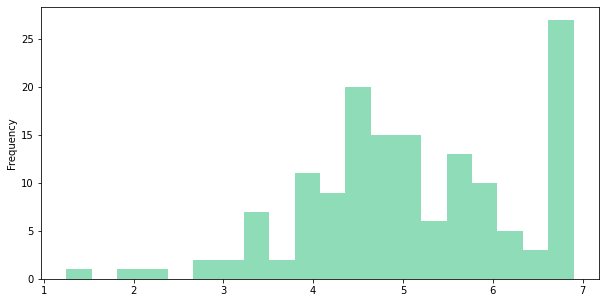

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

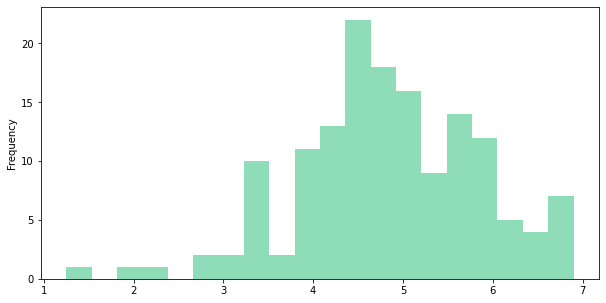

In [9]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [10]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,3.338054
1,1.4,5.926390
2,1.3,3.480803
3,1.5,1.250328
4,1.4,6.847236
5,1.7,5.221052
6,1.4,6.637406
7,1.5,4.957717
8,1.4,2.844502
9,1.5,2.818913


###### Выброс исчез

## Построение гистограмы для "petal.width"

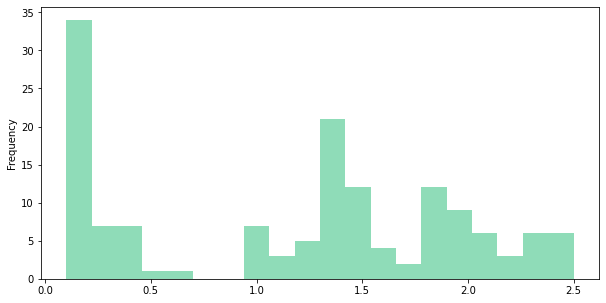

In [11]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [12]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

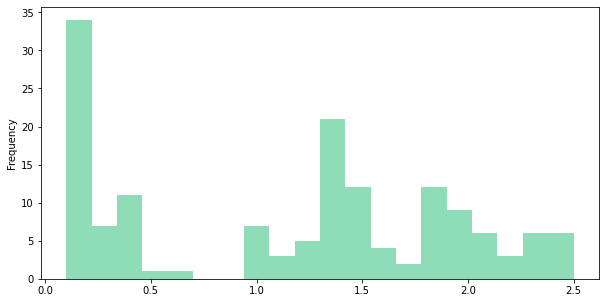

In [13]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [14]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    0.417752
146    0.417752
147    0.417752
148    0.417752
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)
### и проверим результаты по критерию $\chi^2$

array([21.,  5.,  9.,  1.,  1.,  0.,  0.,  7.,  3.,  5., 20., 11.,  3.,
        2.,  7.,  7.,  5.,  2.,  5.,  5.])

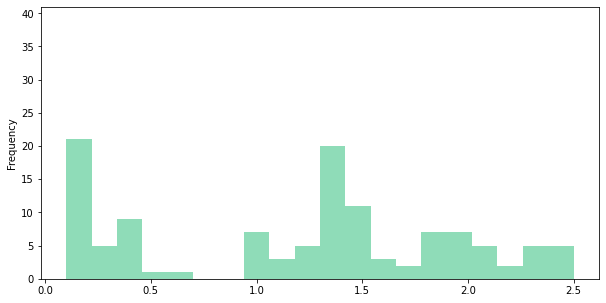

In [15]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

# фиксируем значения гистограммы (с разными BINS)
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);
b2 = 5
b_before_2, n_before_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

# значения столбиков гистограммы
b_before

In [16]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [17]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,2.197341
1,0.652415
2,1.469554
3,0.897432
4,1.306785
...,...
145,1.233083
146,1.155102
147,0.838159
148,0.545363


In [18]:
df_corr.min() # больше нуля :-)

petal.width   -0.258146
dtype: float64

### Заполняем пропуски

In [19]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,0.824382
1,0.4,1.750354
2,0.2,1.384108
3,0.2,1.258019
4,0.2,1.534268
5,0.2,1.321097
6,0.4,0.966719
7,0.1,1.661459
8,0.2,0.827263
9,0.2,1.529827


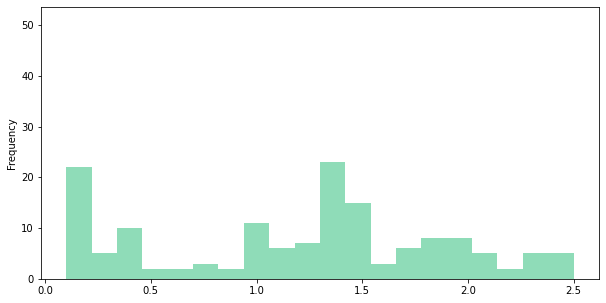

In [20]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы c bins = 20
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);
# и bins = 10
b_after_2, n_after_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

### Почти похоже на исходный :-)

#### ... но так ли это
#### используем критерий $\chi^2$

In [21]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare
print (f"ДО\n {b_before} \nПОСЛЕ\n {b_after}")
_, p_value = chisquare(b_before, b_after)
print(f"p_value = {p_value}")

ДО
 [21.  5.  9.  1.  1.  0.  0.  7.  3.  5. 20. 11.  3.  2.  7.  7.  5.  2.
  5.  5.] 
ПОСЛЕ
 [22.  5. 10.  2.  2.  3.  2. 11.  6.  7. 23. 15.  3.  6.  8.  8.  5.  2.
  5.  5.]
p_value = 0.7809992972604638


#### меняем bins

In [22]:
print (f"ДО\n {b_before_2} \nПОСЛЕ\n {b_after_2}")
_, p_value_2 = chisquare(b_before_2, b_after_2)
print(f"p_value = {p_value_2}")

ДО
 [36.  8. 39. 19. 17.] 
ПОСЛЕ
 [39. 18. 51. 25. 17.]
p_value = 0.039596216053777215


#### _...нужен иной подход ?_


### Снова генерируем пропуски, но в этот раз удаляем 

In [23]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,0.417752,Virginica
148,6.2,3.4,5.4,0.417752,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [24]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,5.134428,2.300000,Virginica
119,6.0,2.2,5.000000,1.500000,Virginica
120,6.9,3.2,5.700000,2.300000,Virginica
121,5.6,2.8,4.900000,2.000000,Virginica
122,7.7,2.8,6.700000,2.000000,Virginica
123,6.3,2.7,4.900000,1.800000,Virginica
124,6.7,3.3,5.700000,2.100000,Virginica
147,6.5,3.0,5.200000,0.417752,Virginica
148,6.2,3.4,5.400000,0.417752,Virginica
149,5.9,3.0,5.100000,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [25]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,3.338054,0.2,Setosa
1,4.9,3.0,5.926390,0.2,Setosa
2,4.7,3.2,3.480803,0.2,Setosa
3,4.6,3.1,1.250328,0.2,Setosa
4,5.0,3.6,6.847236,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,1.250328,0.2,Setosa
4,5.0,3.6,6.847236,0.2,Setosa


In [26]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.643674,0.4,Setosa
1,5.012766,3.440426,4.643674,0.4,Setosa
2,5.012766,3.440426,4.643674,0.4,Setosa
3,4.600000,3.100000,1.250328,0.2,Setosa
4,5.000000,3.600000,6.847236,0.2,Setosa


## Extra case. Infinity

In [27]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,6.041050,inf,Setosa
16,5.4,3.9,4.463931,-inf,Setosa
17,5.1,3.5,6.600634,inf,Setosa
18,5.7,3.8,3.489652,-inf,Setosa


### Гистограмма не строится при наличии inf

In [28]:
data["petal.width"].describe()

count    128.000000
mean            NaN
std             NaN
min            -inf
25%        0.575000
50%        1.300000
75%        1.671095
max             inf
Name: petal.width, dtype: float64

In [29]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [30]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,5.702964,0.2,Setosa
15,5.7,4.4,6.041050,NaN,Setosa
16,5.4,3.9,4.463931,NaN,Setosa
17,5.1,3.5,6.600634,NaN,Setosa
18,5.7,3.8,3.489652,NaN,Setosa
19,5.1,3.8,4.225348,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

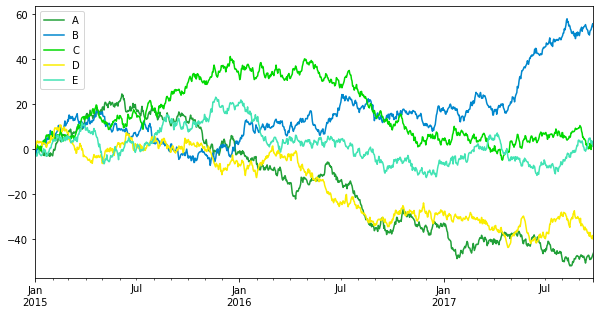

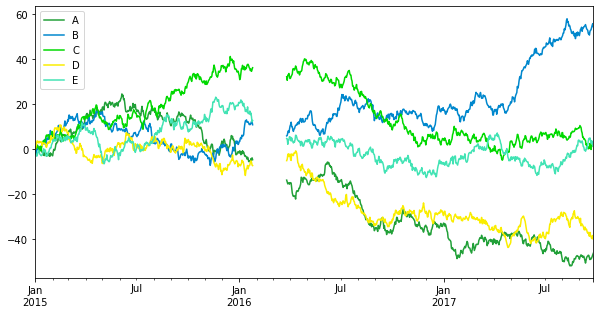

In [31]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

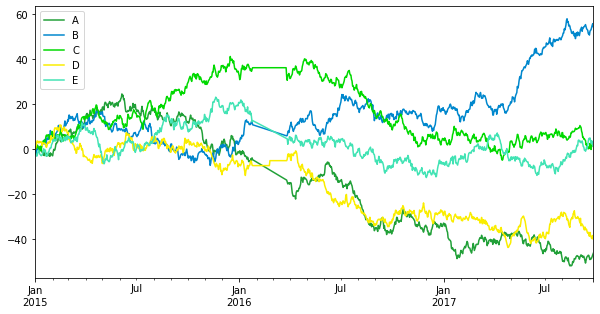

In [32]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [33]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject       Before                                             Recycled  \
type               A          B          C         D          E         A   
2016-02-05 -7.826708   7.337671  34.147787 -7.925335  10.802728 -6.399672   
2016-02-06 -8.288926   7.514674  34.931090 -6.802209  10.241830 -6.548493   
2016-02-07 -9.265739   8.857397  37.068754 -6.661555   8.612527 -6.697315   
2016-02-08 -9.265148   8.507001  38.146563 -6.051874   6.961319 -6.846136   
2016-02-09 -8.138166   9.265678  38.333647 -6.168279   6.512599 -6.994958   
2016-02-10 -6.834049   9.692516  36.916557 -7.364731   5.667673 -7.143779   
2016-02-11 -6.765529  10.125581  35.993475 -6.038596   5.874445 -7.292601   
2016-02-12 -7.539260  11.067157  36.660145 -5.077231   5.716550 -7.441422   
2016-02-13 -7.562708   9.749791  36.166243 -6.441630   4.671035 -7.590244   
2016-02-14 -9.254167  10.013153  33.704231 -5.479884   3.633437 -7.739065   
2016-02-15 -8.366243   9.340792  32.792828 -5.179077   4.068664 -7.887887   
2016-02-16 -9.277548   8.439354  31.927241 -4.471343   5.103202 -8.036708   
2016-02-17 -8.920037   8.713576  31.584718 -4.513264   5.460087 -8.185530   
2016-02-18 -7.905495  10.067258  32.485732 -3.362338   3.704389 -8.334351   
2016-02-19 -8.250734  10.758213  33.583532 -4.144029   2.844156 -8.483173   
2016-02-20 -7.067606  11.330459  33.096484 -2.951088   2.392623 -8.631994   
2016-02-21 -8.469160   9.579708  33.716984 -3.867470   1.756604 -8.780816   
2016-02-22 -9.413454  10.382745  31.921406 -3.166912   1.918604 -8.929637   
2016-02-23 -9.049965  10.981422  31.246353 -3.009908   1.600446 -9.078459   
2016-02-24 -8.492892   9.628183  32.302095 -1.665497   0.929871 -9.227280   

subject                                               
type               B          C         D          E  
2016-02-05  9.845838  36.055888 -7.394123  11.179021  
2016-02-06  9.764854  36.055888 -7.394123  11.049968  
2016-02-07  9.683870  36.055888 -7.394123  10.920818  
2016-02-08  9.602886  36.055888 -7.394123  10.791571  
2016-02-09  9.521902  36.055888 -7.394123  10.662227  
2016-02-10  9.440918  36.055888 -7.394123  10.532786  
2016-02-11  9.359934  36.055888 -7.394123  10.403249  
2016-02-12  9.278950  36.055888 -7.394123  10.273616  
2016-02-13  9.197966  36.055888 -7.394123  10.143886  
2016-02-14  9.116982  36.055888 -7.394123  10.014061  
2016-02-15  9.035998  36.055888 -7.394123   9.884139  
2016-02-16  8.955014  36.055888 -7.394123   9.754122  
2016-02-17  8.874030  36.055888 -7.394123   9.624009  
2016-02-18  8.793046  36.055888 -7.394123   9.493801  
2016-02-19  8.712062  36.055888 -7.394123   9.363497  
2016-02-20  8.631078  36.055888 -7.394123   9.233099  
2016-02-21  8.550094  36.055888 -7.394123   9.102605  
2016-02-22  8.469110  36.055888 -7.394123   8.972017  
2016-02-23  8.388126  36.055888 -7.394123   8.841334  
2016-02-24  8.307142  36.055888 -7.394123   8.710557

In [34]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [35]:
type(accurancy)

pandas.io.formats.style.Styler

In [36]:
accurancy.to_excel("accurancy.xlsx") # xlsx only !!!!!!!!